# 3D Rayleigh-Bénard: Equivariant Convolutional Autoencoder

In [17]:
%load_ext autoreload
%autoreload 2

import os
from IPython.display import Video

from utils import training
from utils.model_building import build_model
from utils.evaluation import load_latent_sensitivity
from utils.visualization import show_latent_patterns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hyperparameters

In [15]:
MODEL_TYPE = '3DCNN' # steerableCNN, steerable3DCNN, CNN, 3DCNN

HYPERPARAMETERS = {
    'simulation_name': 'x48_y48_z32_Ra2500_Pr0.7_t0.01_snap0.125_dur300',
    'rots': 4,
    'flips': True,
    'latent_channels': 32,
    'h_kernel_size': 3,
    'v_kernel_size': 5,
    'drop_rate': 0.2,
    'nonlinearity': 'ELU'
}

match MODEL_TYPE:
    case 'steerableCNN':
        encoder_channels = {
            (True, 4): (8, 16, 32, 64)
        }[(HYPERPARAMETERS['flips'], HYPERPARAMETERS['rots'])]
    case 'steerable3DCNN':
        encoder_channels = {
            (True, 4): (24, 48, 96, 192)
        }[(HYPERPARAMETERS['flips'], HYPERPARAMETERS['rots'])]
    case 'CNN':
        encoder_channels = (16, 32, 66, 160)
    case '3DCNN':
        encoder_channels = (40, 80, 168, 320)

## Model Definition

In [18]:
model = build_model(MODEL_TYPE, encoder_channels=encoder_channels, **HYPERPARAMETERS)

model.summary()

+--------------+---------------------------+------------+
| Layer        | Output shape [c, w, d, h] | Parameters |
+--------------+---------------------------+------------+
| Input        |      [4, 48, 48, 32]      |          0 |
| EncoderConv1 |      [40, 48, 48, 32]     |      7,280 |
| Pooling1     |      [40, 24, 24, 16]     |          0 |
| EncoderConv2 |      [80, 24, 24, 16]     |    144,160 |
| Pooling2     |      [80, 12, 12, 8]      |          0 |
| EncoderConv3 |      [168, 12, 12, 8]     |    605,136 |
| Pooling3     |       [168, 6, 6, 4]      |          0 |
| EncoderConv4 |       [320, 6, 6, 4]      |  2,419,840 |
| Pooling4     |       [320, 3, 3, 2]      |          0 |
| LatentConv   |       [32, 3, 3, 2]       |    460,864 |
| DecoderConv1 |       [320, 3, 3, 2]      |    461,440 |
| Upsampling1  |       [320, 6, 6, 4]      |          0 |
| DecoderConv2 |       [168, 6, 6, 4]      |  2,419,536 |
| Upsampling2  |      [168, 12, 12, 8]     |          0 |
| DecoderConv3

## Load Trained Model

In [3]:
MODEL_NAME = '3Dcnn' # 3Dcnn, cnn, D4cnn, ...
TRAIN_NAME = 'training1_lr1e-3'
EPOCH = -1

models_dir = './trained_models'
model = training.build_and_load_trained_model(models_dir, MODEL_NAME, TRAIN_NAME, EPOCH)

/upb/users/f/frommef/profiles/unix/cs/rb-equivariant-cnns/experiments/utils/training.py:220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)

Loaded state at epoch 149 with an early stop count of 0.


## Evaluation

### Output Animation

In [4]:
FEATURE = 't' # t, u, v, w
DIM = 'height' # width, depth, height

anim_dir = os.path.join('.', 'animations', MODEL_NAME, TRAIN_NAME)
Video(os.path.join(os.path.join(anim_dir, FEATURE), f'{DIM}.mp4'))

### Latent Space Visualization (Input Sensitivity)

In [6]:
sensitivity_dir = os.path.join('.', 'results', MODEL_NAME, TRAIN_NAME)
avg_sensitivity, avg_abs_sensitivity, n = load_latent_sensitivity(sensitivity_dir, 'latent_sensitivity')

print(f'Latent sensitivity averaged over {n} samples')

/upb/users/f/frommef/profiles/unix/cs/rb-equivariant-cnns/experiments/utils/evaluation.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sensitivity_data = torch.load(os.

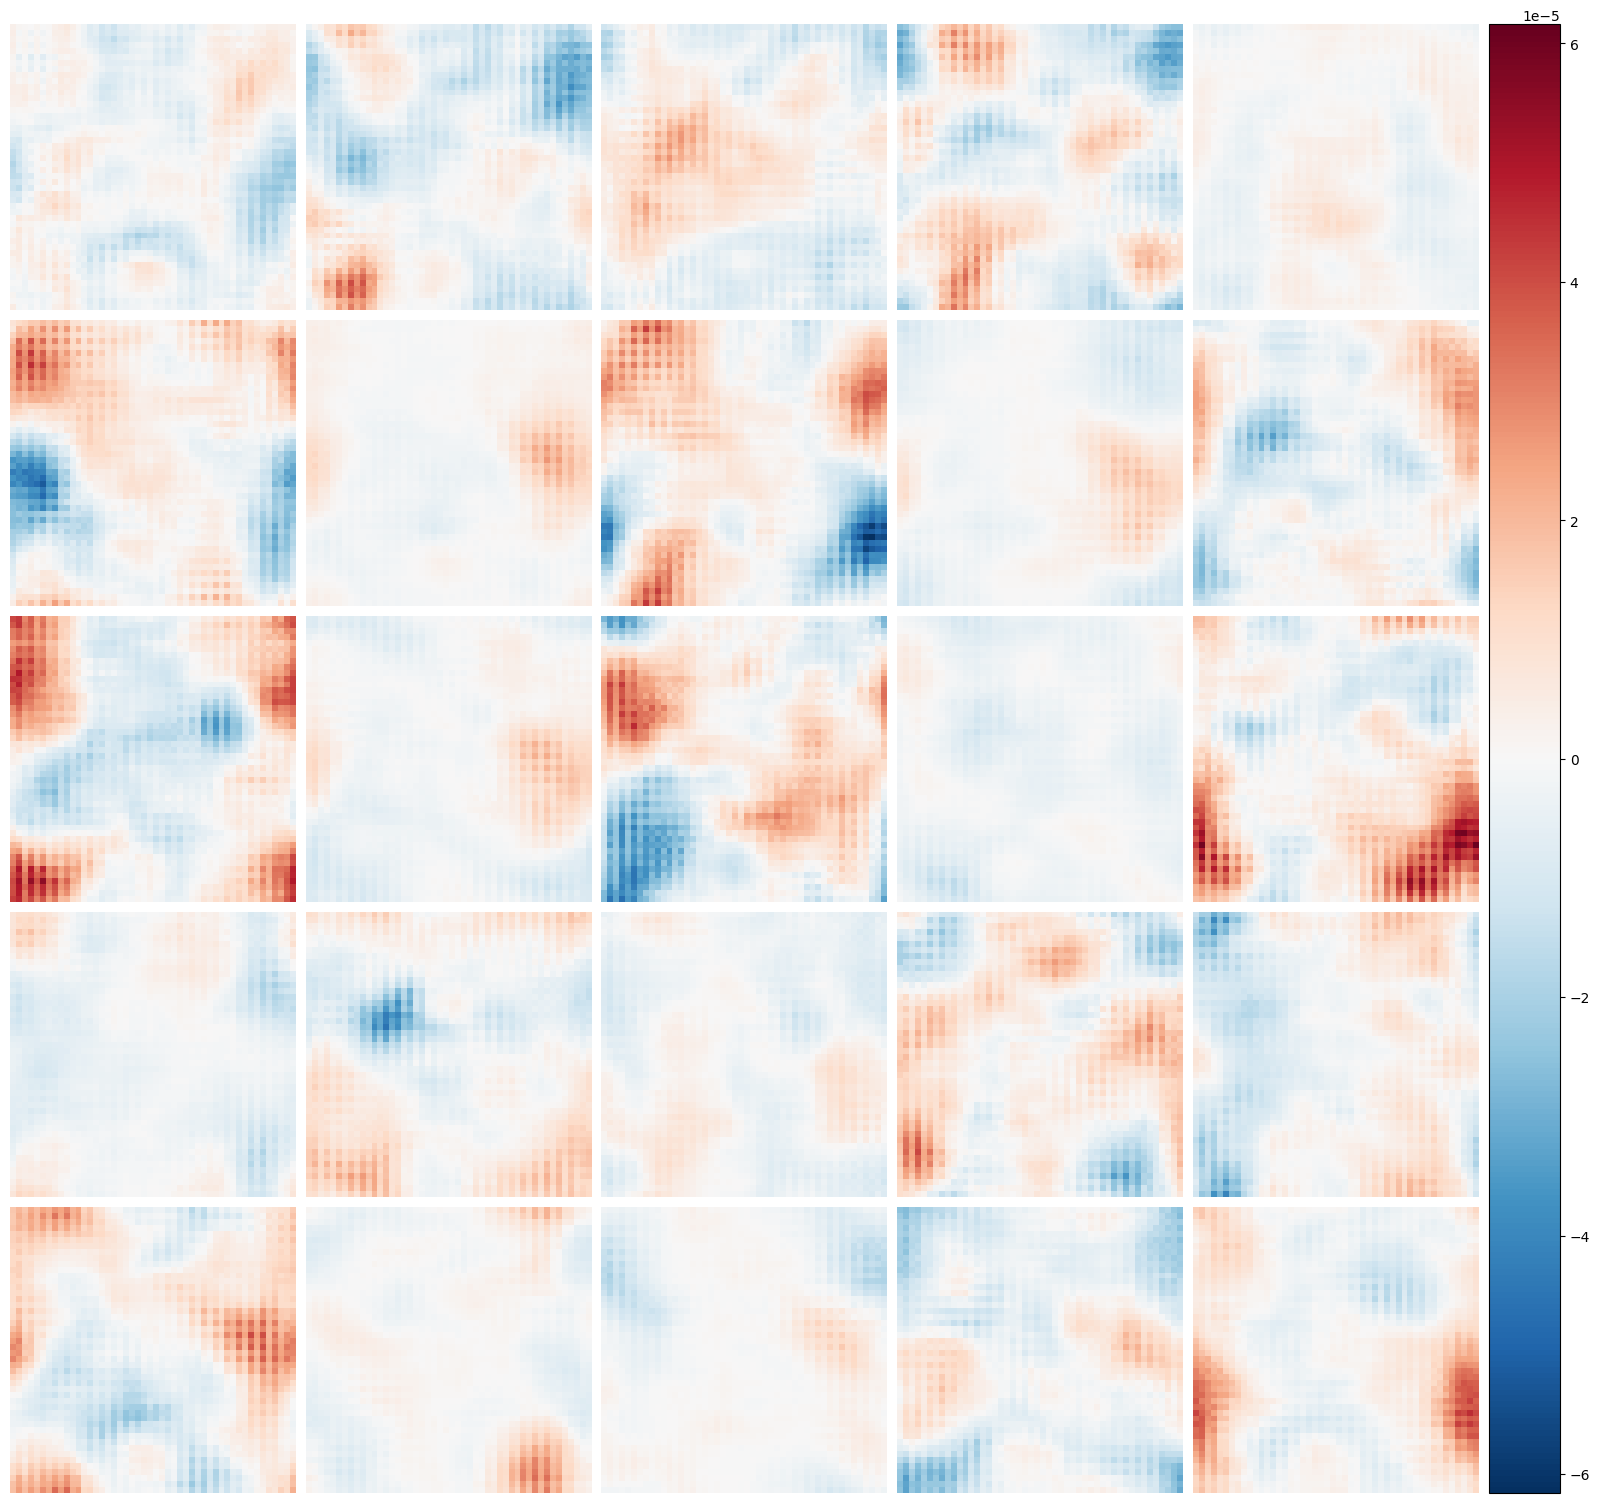

In [14]:
ABS_SENSITIVITY = False
FEATURE = 't'
SLICE = 0
AXIS = 2
NUM_PATTERNS = 25

# TODO why does it look weird at axis 0, 1?


sensitivity_data = avg_abs_sensitivity if ABS_SENSITIVITY else avg_sensitivity
channel = 'tuvw'.index(FEATURE)
show_latent_patterns(avg_sensitivity, ABS_SENSITIVITY, NUM_PATTERNS, channel, SLICE, AXIS)